In [1]:
from __future__ import division
import os, sys, time, random
import math
import scipy
from scipy import constants
import torch
from torch import nn, optim
from torch import autograd
from torch.autograd import grad
import autograd.numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
from scipy.constants import pi

In [3]:
class Potential(nn.Module):
    def __init__(self):
        super(Potential,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(1,128),
            nn.Tanh()
        )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(32,128),
#             nn.Tanh()
#         )
        self.hidden1 = nn.Sequential(
            nn.Linear(128,128),
            nn.Tanh()
        )
        self.out = nn.Sequential(
            nn.Linear(128,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = x + self.hidden1(x)
#         x = x + self.hidden2(x)
        x = 12.5*self.out(x)
        return x

In [4]:
#Wave function equation here

def hermite(n,x):
    if n==0:
        return 1
    elif n==1:
        return 2*x
    else:
        return 2*x*hermite(n-1,x)-2*(n-1)*hermite(n-2,x) #recursion

def harmonic(m,h,w,n,x):
    #Normalization:
    norm=((m*w)/(math.pi*h))**(1/4)
    term1=(math.factorial(n))*(2**n)
    term2=(hermite(n,x)/math.sqrt(term1))
    expterms=(-1.0*m*w*x*x)/(2*h)
    #print(norm*term2,expterms,x)
    evalh=norm*term2*torch.exp(expterms)
    
    #print(norm,term1,term2,evalh)
    return evalh 
def init_wave_function(x): 
    # Instead of the wave function return the probability distribution
    #return harmonic(1,1,1,0,x)*harmonic(1,1,1,0,x)#This is the probability density, |Psi*Psi|**2 of the harmonic oscilator 
    return harmonic(1,1,1,2,x)*harmonic(1,1,1,2,x)



In [5]:
potential = Potential()

optimizer = torch.optim.Adam(potential.parameters(), lr = .001)


def new_prob_dist(batch):
    output = torch.sqrt(init_wave_function(batch))
    output.requires_grad_(True)
    potential_energy = potential(batch)
   # potential_energy.requires_grad_(True)
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    conserve_energy = grad(kinetic_energy/(2*output) - potential_energy, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
  
    return conserve_energy  

In [6]:
x_range = [-5,5]
#Better to get from data
def sample_x(size):
    '''
    Uniform random x sampling within range
    '''
    x = (x_range[0] - x_range[1]) * torch.rand(size,1) + x_range[1]
    return x


In [7]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.data)

In [8]:
data = sample_x(2500)
dataset = MyDataset(data)
loader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [9]:
num_epochs = 1000
loss = []
for epoch in range(num_epochs):
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch, requires_grad=True)
        optimizer.zero_grad()
      
        total_energy = new_prob_dist(n_data)
      
        error = (total_energy**2).mean() + ((potential(n_data)-potential(-n_data))**2).mean()
        
        error.backward(retain_graph=True)
        #error.backward()
        optimizer.step()
    loss.append(error)
 


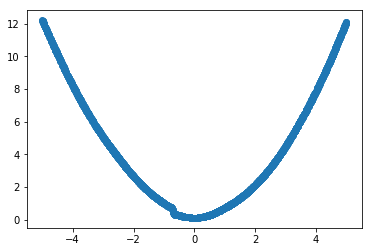

In [11]:
plt.scatter(data.detach().numpy(), potential(data).detach().numpy())

In [14]:
#plt.scatter(data.detach().numpy(), pow((pow(data.detach().numpy(),2)-potential(data).detach().numpy()),2))
torch.save(potential.state_dict(), 'potential_harmonic_oscillator_expt.pkl')
#save the optimizer state too

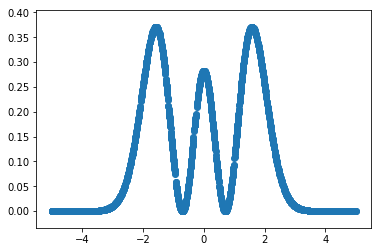

In [12]:
plt.scatter(data.detach().numpy(), init_wave_function(data).detach().numpy())

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, title, show, xlabel, ylabel, legend


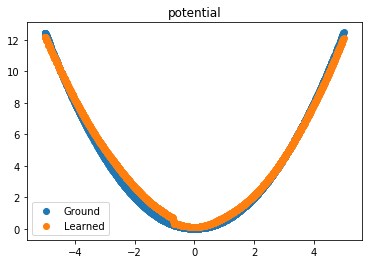

In [14]:
plt.scatter(data.detach().numpy(),.5* pow(data.detach().numpy(),2))
plt.scatter(data.detach().numpy(), potential(data).detach().numpy())
title("potential")
legend(['Ground','Learned'])
show()

In [18]:
def learned_energy(batch):
    batch.requires_grad_(True)
    output = torch.sqrt(init_wave_function(batch))
    output.requires_grad_(True)
    potential_energy = potential(batch)
   # potential_energy.requires_grad_(True)
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    energy = -kinetic_energy/(2*output) + potential_energy
    
    return energy

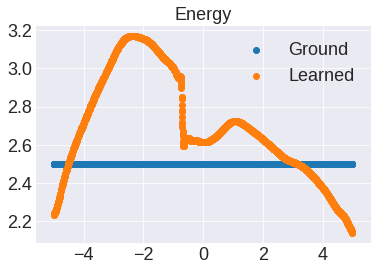

In [36]:
plt.scatter(data.detach().numpy(), (torch.ones_like(data)*2.5).numpy())
plt.scatter(data.detach().numpy(), learned_energy(data).detach().numpy())
title("Energy")
legend(['Ground','Learned'])
show()

Rest of the notebook can be ignored as it is just used to create pretty pictures.

In [20]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

In [21]:
x_coord = sample_x(4000)

In [22]:
x_coord.detach().numpy()

array([[ 4.942854 ],
       [-4.083021 ],
       [-0.475945 ],
       ...,
       [ 2.1586604],
       [ 4.4064994],
       [ 1.3610935]], dtype=float32)

In [23]:
import pandas as pd

In [24]:
learned_potential = potential.cpu()(x_coord).detach().numpy()
learned_potential[3000],x_coord.detach().numpy()[3000]

(array([0.23872107], dtype=float32), array([-0.46266174], dtype=float32))

In [25]:
output=[]
for i in range(0,len(learned_potential)):
    output.append((x_coord.detach().numpy()[i][0],learned_potential[i][0]))

In [26]:
sorted_output = sorted(output, key=lambda x: x[0])

In [27]:
xsorted = []
potsorted=[]
for i in sorted_output:
    xsorted.append(i[0])
    potsorted.append(i[1])

In [28]:
dictlearned={'x':xsorted,'potential_learned':potsorted}

In [29]:
ground = .5* pow(x_coord.detach().numpy(),2)
output_ground=[]
for i in range(0,len(ground)):
    output_ground.append((x_coord.detach().numpy()[i][0],ground[i][0]))
sorted_ground = sorted(output_ground, key=lambda x: x[0])

In [30]:
xgroundsorted = []
potgroundsorted=[]
for i in sorted_ground:
    xgroundsorted.append(i[0])
    potgroundsorted.append(i[1])

In [31]:
dictplot= {'x':xsorted,'Learned Potential':potsorted, 'Ground Potential':potgroundsorted}

In [32]:
df=pd.DataFrame(dictplot)

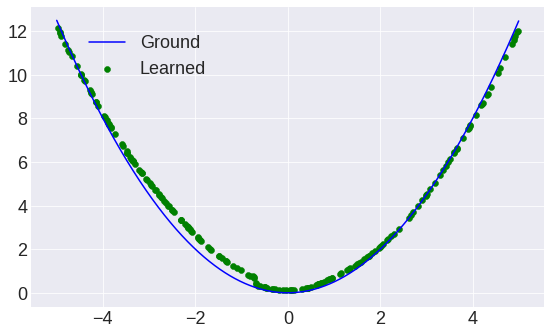

In [37]:
x = sample_x(200)
fig = plt.figure(figsize=[8, 5])
ax = fig.add_subplot()
# ax.set_title('Ground and Learned Potentials')
#ax.set_xlabel('Position')
#ax.set_ylabel('Potential')
plt.plot(xgroundsorted,potgroundsorted,color='b',linewidth=1.5)
plt.scatter(x, potential.cpu()(x).detach().numpy(),color='g',linestyle='-',marker='o',linewidth=0.5)
#plt.plot(xsorted,potsorted,color='g',linewidth='1',alpha=0.5)
# Create an inset outside the axes
# plt.suptitle("Ground and Learned Potentials", fontsize=13, fontweight=0, color='black', style='italic')

plt.legend(['Ground','Learned'],bbox_to_anchor=(0.1, 0.93), loc='upper left', borderaxespad=0.0)
# Create an inset with a 2-tuple bounding box. Note that this creates a
# bbox without extent. This hence only makes sense when specifying
# width and height in absolute units (inches).
# axins2 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.05, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)

# axins2.plot(xgroundsorted,potgroundsorted,label='Ground',color='b')
# axins2.set_xlabel('Position')
# axins2.set_ylabel('Potential')
# axins2.set_title('Ground Potential')

# axins3 = inset_axes(ax, width=2, height=1.3,
#                     bbox_to_anchor=(0.39, 0.55),
#                     bbox_transform=ax.transAxes, loc=3, borderpad=1)
# axins3.plot(xgroundsorted,potsorted,label='Learned',color='g')
# axins3.set_xlabel('Position')
# axins3.set_ylabel('Potential')
# axins3.set_title('Learned Potential')

major_ticks_x = np.arange(-5, 5, 1)
minor_ticks_x = np.arange(-5, 5, 1)
major_ticks_y = np.arange(0, 13, 2)
minor_ticks_y = np.arange(0, 13, 2)
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
plt.rc('font', size=18)
plt.rc('axes', titlesize=18) 

plt.tight_layout()
plt.savefig('potential_from_dist.png',dpi=1200)
